<a href="https://colab.research.google.com/github/regifukuchi/UFABC_UofC_datasets/blob/main/notebooks/BMC_RIC_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Three-dimensional kinematics dataset of running - interlaboratory comparison

> Reginaldo K Fukuchi, Marcos Duarte and Reed Ferber

This dataset is located on figshare, however it is not easy to run this notebook in the cloud and load the data from figshare repository (although there is a figshare API).  

To make it possible to run this notebook in the cloud, the data will be loaded from a copy in the GitHub repository (the dataset is small enough to be stored on GitHub).

## Setup

In [1]:
#@title ### import libraries {display-mode: "form"}
import sys, os, platform, glob, datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

print(f'Python {sys.version} on {platform.platform()}')
print(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

# import/install libraries
def import_or_install(pkgs):
    """pkgs: list (or list of lists) of packages: [['pandas', 'pd'], 'ipympl']
    """
    import importlib
    for pkg in pkgs:
        if isinstance(pkg, str) or len(pkg)==1: pkg = [pkg, pkg]
        x, y = pkg[0], pkg[1]
        try:
            globals()[y] = importlib.import_module(x)  # need globals inside function
        except ImportError:
            !pip install -q --upgrade $x
            globals()[y] = importlib.import_module(x)
    print('\n'.join(f' {m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

import_or_install([['pingouin', 'pg'], 'spm1d', 'ipympl'])

%matplotlib widget
if os.getenv("COLAB_RELEASE_TAG"):  # or "google.colab" in sys.modules
    from google.colab import output
    output.enable_custom_widget_manager()

import warnings
warnings.filterwarnings("ignore")

Python 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0] on Linux-5.15.107+-x86_64-with-glibc2.31
10/07/2023 20:30:43
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00
 platform==1.0.8
 numpy==1.22.4
 pandas==1.5.3
 seaborn==0.12.2
 pingouin==0.5.3
 spm1d==0.4.19 (2023-06-22)
 ipympl==0.9.3


### Configuration

In [2]:
#@title #### Plot style {display-mode: "form"}
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)

pd.set_option('display.precision', 3)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Dataset location

In [3]:
#@title #### Path {display-mode: "form"}
# LOCAL
path2 = Path('../data')
os_sep = os.sep
metadata_fname = 'metadata.csv'
if not os.path.isfile(path2 / metadata_fname):
    path2 = Path('data')
    if not os.path.isfile(path2 / metadata_fname):
        path2 = Path('.')
        if not os.path.isfile(path2 / metadata_fname):
            print('Dataset not found locally. It will be loaded from the GitHub repo.')
            # REMOTE
            path2 = 'https://raw.githubusercontent.com/BMClab/datasets/master/BMC_RIC/data'
            os_sep = '/'

path2 = str(path2)
print(f'Dataset location: {path2}')

Dataset not found locally. It will be loaded from the GitHub repo.
Dataset location: https://raw.githubusercontent.com/BMClab/datasets/master/BMC_RIC/data


## Helping functions

In [4]:
#@title #### Functions {display-mode: "form"}
def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats = pd.concat([stats, stat], axis=0)
    stats.drop(columns=['BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'T': '{:.3f}', 'p-val': '{:.3f}', 'cohen-d': '{:.3f}'}
                              ).apply(sig_red, subset='p-val', axis=1))
    return stats

def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    is_sig = col < alpha
    return ['color: red' if x else 'color: None' for x in is_sig]

def describe(df, by, var=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    display(x.style.apply(sig_red,
                          subset=[col for col in x.columns if col[1] == 'normality'])
                   .format(lambda y: f'{y:.0f}' if int(y)==y else f'{y:.3f}'))
    return x

## Load metadata

In [5]:
#@title #### Metadata {display-mode: "form"}
metadata = pd.read_csv(f'{path2}{os_sep}{metadata_fname}', index_col=0)
display(metadata)

,ID,Filename,Speed,Age,Height,Mass,Group
0,BMC01,BMC01angs.txt,2.500,22,181.0,62.00,BMC
1,BMC02,BMC02angs.txt,2.500,38,183.0,80.00,BMC
2,BMC03,BMC03angs.txt,2.500,34,177.0,65.40,BMC
3,BMC04,BMC04angs.txt,2.500,33,168.0,57.05,BMC
4,BMC05,BMC05angs.txt,2.500,32,169.0,60.00,BMC
5,BMC06,BMC06angs.txt,2.500,39,177.8,78.30,BMC
6,BMC07,BMC07angs.txt,2.500,31,182.9,66.70,BMC
7,BMC08,BMC08angs.txt,2.500,36,180.0,69.00,BMC
8,BMC09,BMC09angs.txt,2.500,51,173.2,63.15,BMC
9,BMC10,BMC10angs.txt,2.500,30,179.5,75.00,BMC


### Statistics for Age, Height and Mass per Group

In [6]:
#@title #### Tables with results {display-mode: "form"}
cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
display(metadata[cols].groupby('Group').describe().stack().transpose().style.format('{:.2f}'))

cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
describe(metadata[cols], 'Group', var=['count', 'median', 'min', 'max', 'mean', 'std', normality]);

stats = ttest(metadata, cols[2:], 'Group', levels=['BMC', 'RIC'])

,T,dof,alternative,p-val,CI95%,cohen-d
BMC-RIC,,,,,,
Height,-0.276,44,two-sided,0.784,[-3.54 2.68],0.081
Mass,-3.694,44,two-sided,0.001,[-12.91 -3.79],1.089
Speed,1.356,44,two-sided,0.182,[-0. 0.02],0.400


## Ensemble time-series

In [7]:
#@title #### Coordinate system conventions {display-mode: "form"}
labs   = metadata['ID'].str[:3].unique()
joints  = ['Hip', 'Knee', 'Ankle']
axes    = ['Z', 'X', 'Y']
planes  = ['Sagittal', 'Frontal', 'Transverse']
angles  = [f'{joint}_{axis}' for joint in joints for axis in axes]
angles2 = [f'{joint} {plane}' for joint in joints for plane in planes]
print(f'Joints: {joints}')
print('Planes (axes):', [f'{plane} ({axis})' for plane, axis in zip(planes, axes)])
print(f'Columns in data: {angles}')
# angle convention
pos_angs = [['EXT', 'ABD', 'ER'], ['FLX', 'ABD', 'ER'], ['PF', 'EVE', 'ABD']]
neg_angs = [['FLX', 'ADD', 'IR'], ['EXT', 'ADD', 'IR'], ['DF', 'INV', 'ADD']]

Joints: ['Hip', 'Knee', 'Ankle']
Planes (axes): ['Sagittal (Z)', 'Frontal (X)', 'Transverse (Y)']
Columns in data: ['Hip_Z', 'Hip_X', 'Hip_Y', 'Knee_Z', 'Knee_X', 'Knee_Y', 'Ankle_Z', 'Ankle_X', 'Ankle_Y']


In [ ]:
# APAGAR ANTES DE PUBLICAR

# reorder planes of angles
for fname in metadata['Filename']:
    print(fname[:5], end=' ')
    df = pd.read_csv(f'{path2}{os_sep}{fname}', header=0, sep='\t', index_col=0)
    if df.columns[0][4] == 'Z':
        print('Planes already reordered.')
        break
    order = [np.array([2, 0, 1, 5, 3, 4, 8, 6, 7])+9*i for i in range(int(df.shape[1]/9))]
    order = np.array(order).flatten()
    df = df.iloc[:, order]
    try:
        df.to_csv(f'{path2}{os_sep}{fname}', sep='\t', float_format=None, index=True)
    except:
        print('File not saved in the cloud.')
# rename columns
for fname in metadata['Filename']:
    print(fname[:5], end=' ')
    df = pd.read_csv(f'{path2}{os_sep}{fname}', header=0, sep='\t', index_col=0)
    if df.columns[0] == 'Hip_Z_1':
        print('Columns already renamed.')
        break
    cols = [f'{angle}_{trial}' for trial in range(1, int(df.shape[1]/9)+1) for angle in angles]
    df.columns = cols
    try:
        df.to_csv(f'{path2}{os_sep}{fname}', sep='\t', float_format=None, index=True)
    except:
        print('File not saved in the cloud.')

BMC01 Planes already reordered.
BMC01 Columns already renamed.


In [8]:
#@title #### Load and process all trials {display-mode: "form"}
nsubjects = len(metadata[metadata['Group']==labs[0]]['Filename'])
ang_all = np.full([101, len(joints)*len(axes), nsubjects, len(labs)], np.nan)
ang_m   = np.full([101, len(joints)*len(axes), len(labs)], np.nan)
ang_sd  = np.full([101, len(joints)*len(axes), len(labs)], np.nan)
for l, lab in enumerate(tqdm(labs, desc='Lab')):
    fnames = metadata[metadata['Group']==lab]['Filename']
    for s, subject in enumerate(tqdm(fnames, desc='Trial')):
        try:
            y = np.loadtxt(f'{path2}{os_sep}{subject}', skiprows=1)
            y = y[:, 1:]  # drop time column
        except:
            y = np.nan
            print(f'File {subject} not loaded.')
        ym = np.full([101, len(joints)*len(axes)], np.nan)
        if not np.all(np.isnan(y)):
            for j in range(len(joints)):
                for ax in range(len(axes)):
                    ym[:, 3*j+ax] = np.nanmedian(y[:, 3*j + ax:y.shape[1]-(3*j+ax+1):len(joints)*len(axes)], axis=1)
        ang_all[:, :, s, l] = ym
# Mean and std across subjects
ang_m  = np.nanmean(ang_all, axis=2)
ang_sd = np.nanstd(ang_all, axis=2, ddof=1)

Lab:   0%|          | 0/2 [00:00<?, ?it/s]

Trial:   0%|          | 0/23 [00:00<?, ?it/s]

Trial:   0%|          | 0/23 [00:00<?, ?it/s]

### Plot of angles

File not saved in the cloud.


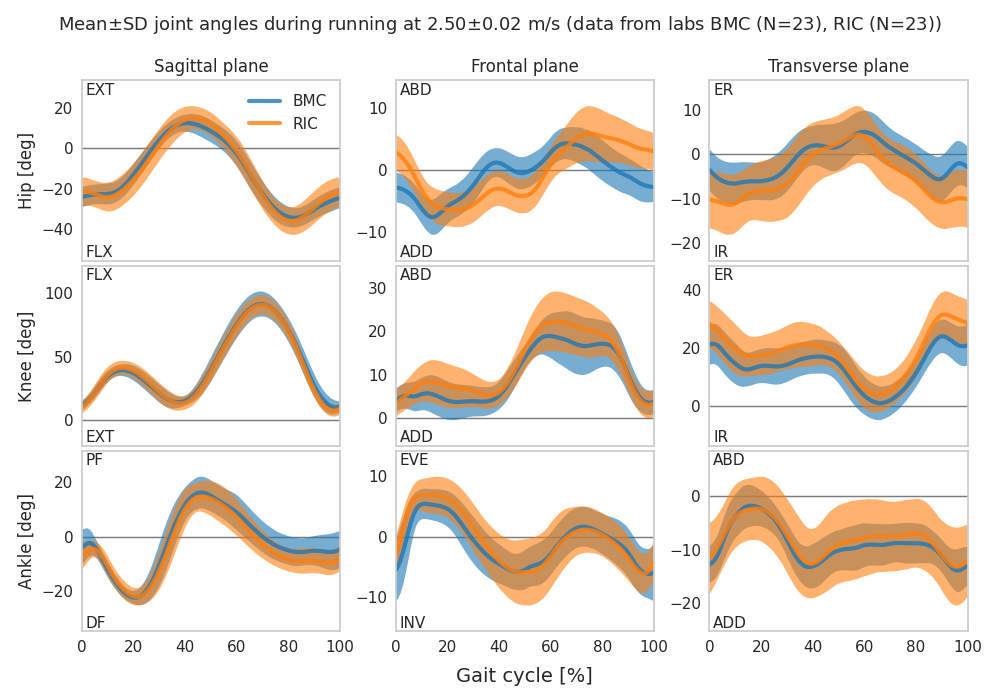

In [9]:
#@title #### Plot {display-mode: "form"}
tn = np.linspace(0, 100, 101)

fig, axs = plt.subplots(3, 3, figsize=(10, 7), sharex=True)
v_m, v_sd = metadata.Speed.mean(), metadata.Speed.std()
labs_s = [f'{lab} (N={len(metadata[metadata["Group"]==lab]["Filename"])})' for lab in labs]
labs_s = ', '.join(labs_s)
fig.suptitle(f'Mean$\pm$SD joint angles during running at {v_m:,.2f}$\pm${v_sd:,.2f} m/s (data from labs {labs_s})', fontsize=13)
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        for l, lab in enumerate(labs):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .3], linestyle='-', zorder=-1)
            axs[j, xyz].plot(tn, ang_m[:, 3*j+xyz, l], label=labs[l], color=colors[l], alpha=.8, lw=3)
            axs[j, xyz].fill_between(tn,
                                     ang_m[:, 3*j+xyz, l] + ang_sd[:, 3*j+xyz, l],
                                     ang_m[:, 3*j+xyz, l] - ang_sd[:, 3*j+xyz, l],
                                     facecolor=colors[l], alpha=.6, edgecolor='none')

        axs[j, xyz].set_ylabel(joint + '-' + planes[xyz])
        axs[j, xyz].set_xlim([0, 100])
        axs[j, xyz].margins(y=0.2)
        axs[j, xyz].grid(False)
        axs[j, xyz].xaxis.set_ticks_position('none')
        axs[j, xyz].yaxis.set_ticks_position('none')
        axs[j, xyz].tick_params(axis='both', which='major', pad=0)
        axs[j, xyz].text(.015, .92, f'{pos_angs[j][xyz]}', fontsize=11, transform=axs[j, xyz].transAxes)
        axs[j, xyz].text(.015, .02, f'{neg_angs[j][xyz]}', fontsize=11, transform=axs[j, xyz].transAxes)
        if j == 0:
            axs[0, xyz].set_title(f'{planes[xyz]} plane')
        if j == 2 and xyz == 1:
            axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
            axs[j, xyz].xaxis.set_label_coords(.5, -.2)
        if xyz == 0:
            axs[j, xyz].set_ylabel(f'{joint} [deg]')
        else:
            axs[j, xyz].set_ylabel('')

fig.align_ylabels(axs[:, 0])
axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.3, w_pad=.05)
try:
    fig.savefig(f'{path2}{os_sep}"labs_angs.png"', bbox_inches='tight')
except:
    print('Figure not saved in the cloud.')
plt.show()

## Descriptive statistics for angles

### Root-mean-square deviation (RMSD)

The root-mean-square deviation (RMSD) is the square root of the average of squared deviations between two samples $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$

### Relative root-mean-square deviation (RMSD rel)

The relative RMSD in percentage (RMSD rel) is the RMSD divided by the absolute mean (AM) between two samples $x$ and $y$ times 100, where AM is:

$$ \mathrm{AM} = \sum_{i=1}^N \frac{|x_i|+|y_i|}{2N} $$

### Absolute maximum difference (AMD)

The maximum difference (AMD) between two samples $x$ and $y$ is:

$$ \mathrm{AMD} = \max \{ |x-y| \} $$

### Relative absolute maximum difference (AMD rel)

The relative maximum difference in percentage (AMD rel) is the AMD divided by the absolute mean (AM) times 100.

In [10]:
#@title #### Table with results {display-mode: "form"}
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays
AMD  = lambda x, y: np.nanmax(np.abs(y - x), axis=0)  #  x and y must be arrays
AM   = lambda x: np.nanmean(np.nanmean(np.abs(x), axis=2), axis=0)  #  x must be 3d arrays
# inter-laboratory stats
rmsd = RMSD(ang_m[:, :, 0], ang_m[:, :, 1])
am = AM(ang_m)
rmsd_r = rmsd/am * 100
amd = AMD(ang_m[:, :, 0], ang_m[:, :, 1])
amd_r = amd/am * 100
# intra-lab stats
rmsd_i = np.sqrt(np.mean((ang_sd**2 * (nsubjects-1)/nsubjects), axis=0))
rmsd_i_rel = rmsd_i / np.nanmean(np.abs(ang_m), axis=0) * 100
stats = pd.DataFrame({'AMD [deg]': amd, 'AMD rel [%]': amd_r,
                      'RMSD [deg]': rmsd, 'RMSD rel [%]': rmsd_r,
                      'RMSD [deg]': rmsd, 'RMSD rel [%]': rmsd_r},
                     index=angles2)
for l, lab in enumerate(labs):
    stats[f'RMSD_{lab} [deg]'] = rmsd_i[:, l]
    stats[f'RMSD_{lab} rel [%]'] = rmsd_i_rel[:, l]
stats['RMSD_All [deg]'] = np.mean(rmsd_i, axis=1)
stats['RMSD_All rel [%]'] = np.mean(rmsd_i_rel, axis=1)

display(stats.style.format('{:.1f}'))
display(stats.describe().T.style.format('{:.1f}'))

df = pd.DataFrame()
vs = [['RMSD [deg]', 'RMSD_All [deg]'], ['RMSD rel [%]', 'RMSD_All rel [%]']]
for v in vs:
    ttest = pg.ttest(stats[v[0]], stats[v[1]])
    ttest.rename(index={'T-test': v[0]}, inplace=True)
    df = pd.concat([df, ttest], axis=0)
df.drop(columns=['alternative', 'BF10', 'power'], inplace=True)
df.index.name = 'Inter-Intra'
display(df)

,AMD [deg],AMD rel [%],RMSD [deg],RMSD rel [%],RMSD_BMC [deg],RMSD_BMC rel [%],RMSD_RIC [deg],RMSD_RIC rel [%],RMSD_All [deg],RMSD_All rel [%]
Hip Sagittal,3.6,20.1,2.0,11.2,5.1,29.3,7.0,38.4,6.0,33.9
Hip Frontal,5.8,171.5,3.6,107.1,2.6,96.4,3.1,76.9,2.9,86.6
Hip Transverse,7.9,162.3,4.0,81.1,4.6,130.2,6.4,103.5,5.5,116.8
Knee Sagittal,3.9,9.4,1.7,4.0,7.6,18.1,6.7,16.3,7.2,17.2
Knee Frontal,4.2,38.6,2.4,22.4,4.3,43.7,4.7,39.7,4.5,41.7
Knee Transverse,8.9,55.9,5.0,31.6,6.0,44.4,6.9,37.9,6.4,41.1
Ankle Sagittal,4.0,41.0,2.4,24.7,5.5,59.2,5.3,52.3,5.4,55.7
Ankle Frontal,3.8,112.1,1.4,41.4,3.5,108.3,3.9,109.4,3.7,108.8
Ankle Transverse,1.9,21.8,1.1,12.5,3.6,40.7,6.5,80.2,5.1,60.5


,count,mean,std,min,25%,50%,75%,max
AMD [deg],9.0,4.9,2.2,1.9,3.8,4.0,5.8,8.9
AMD rel [%],9.0,70.3,62.3,9.4,21.8,41.0,112.1,171.5
RMSD [deg],9.0,2.6,1.3,1.1,1.7,2.4,3.6,5.0
RMSD rel [%],9.0,37.3,34.7,4.0,12.5,24.7,41.4,107.1
RMSD_BMC [deg],9.0,4.8,1.5,2.6,3.6,4.6,5.5,7.6
RMSD_BMC rel [%],9.0,63.4,38.8,18.1,40.7,44.4,96.4,130.2
RMSD_RIC [deg],9.0,5.6,1.4,3.1,4.7,6.4,6.7,7.0
RMSD_RIC rel [%],9.0,61.6,32.3,16.3,38.4,52.3,80.2,109.4
RMSD_All [deg],9.0,5.2,1.3,2.9,4.5,5.4,6.0,7.2
RMSD_All rel [%],9.0,62.5,34.5,17.2,41.1,55.7,86.6,116.8


,T,dof,p-val,CI95%,cohen-d
Inter-Intra,,,,,
RMSD [deg],-4.119,16,8.046e-04,"[-3.91, -1.25]",1.942
RMSD rel [%],-1.545,16,1.420e-01,"[-59.71, 9.38]",0.728


The average variability inter-laboratories (RMSD = 2.6 deg) is lower than the variability intra-laboratories (RMSD BMC = 4.8 deg, RMSD RIC = 5.6 deg).

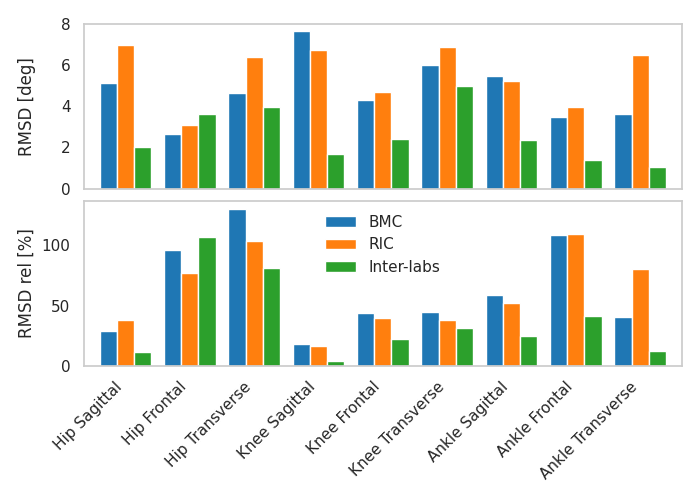

In [11]:
#@title #### Plot with results {display-mode: "form"}
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
stats.iloc[:, [4, 6, 2]].plot.bar(ax=axs[0], width=.8, edgecolor=None, legend=False)
stats.iloc[:, [5, 7, 3]].plot.bar(ax=axs[1], width=.8, edgecolor=None)
axs[0].set_ylabel('RMSD [deg]')
axs[1].set_ylabel('RMSD rel [%]')
axs[1].set_xlabel('')
axs[1].set_xticklabels(angles2, rotation=45, ha='right')
axs[0].grid(False)
axs[1].grid(False)
fig.align_ylabels(axs)
legend = labs.tolist()
legend.extend(['Inter-labs'])
axs[1].legend(legend, loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.2)
plt.show()

## Inference using Statistical Parametric Mapping (SPM)

Statistical Parametric Mapping uses random field theory to make statistical inferences regarding registered (normalized) sets of 1D measurements. See [https://spm1d.org/index.html](https://spm1d.org/index.html).

In [12]:
#@title #### SPM1d inferences {display-mode: "form"}
#fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 5))
spm_t = np.empty((3, 3), dtype=np.object_)
spm_ti = spm_t.copy()
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        ang_bmc = ang_all[:, 3*j+xyz, :, 0].T
        ang_ric = ang_all[:, 3*j+xyz, :, 1].T
        spm_t[j, xyz]  = spm1d.stats.ttest2(ang_bmc, ang_ric, equal_var=False)
        spm_ti[j, xyz] = spm_t[j, xyz].inference(alpha=0.05, two_tailed=True, interp=True)
        print(joint, eixo, '\n', spm_ti[j, xyz])
        #spm_ti[j, xyz].plot(ax=axs[j, xyz])
        #spm_ti[j, xyz].plot_threshold_label(ax=axs[j, xyz], color='red')
        #spm_ti[j, xyz].plot_p_values(ax=axs[j, xyz], size=12)  # offset_all_clusters=(0.1, 0.4)

#fig.tight_layout(w_pad=.1)

Hip Z 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 40.631)
   SPM.fwhm      :  27.10754
   SPM.resels    :  (1, 3.68901)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.91925
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()



Hip X 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 43.245)
   SPM.fwhm      :  18.06163
   SPM.resels    :  (1, 5.53660)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  3.05908
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (0.006, <0.001, <0.001)



Hip Y 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 40.437)
   SPM.fwhm      :  23.29359
   SPM.resels    :  (1, 4.29303)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.97677
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (0.044, 0.017)



Knee Z 
 SPM{t} inf

### Plots of angles and SPM results

File not saved in the cloud.


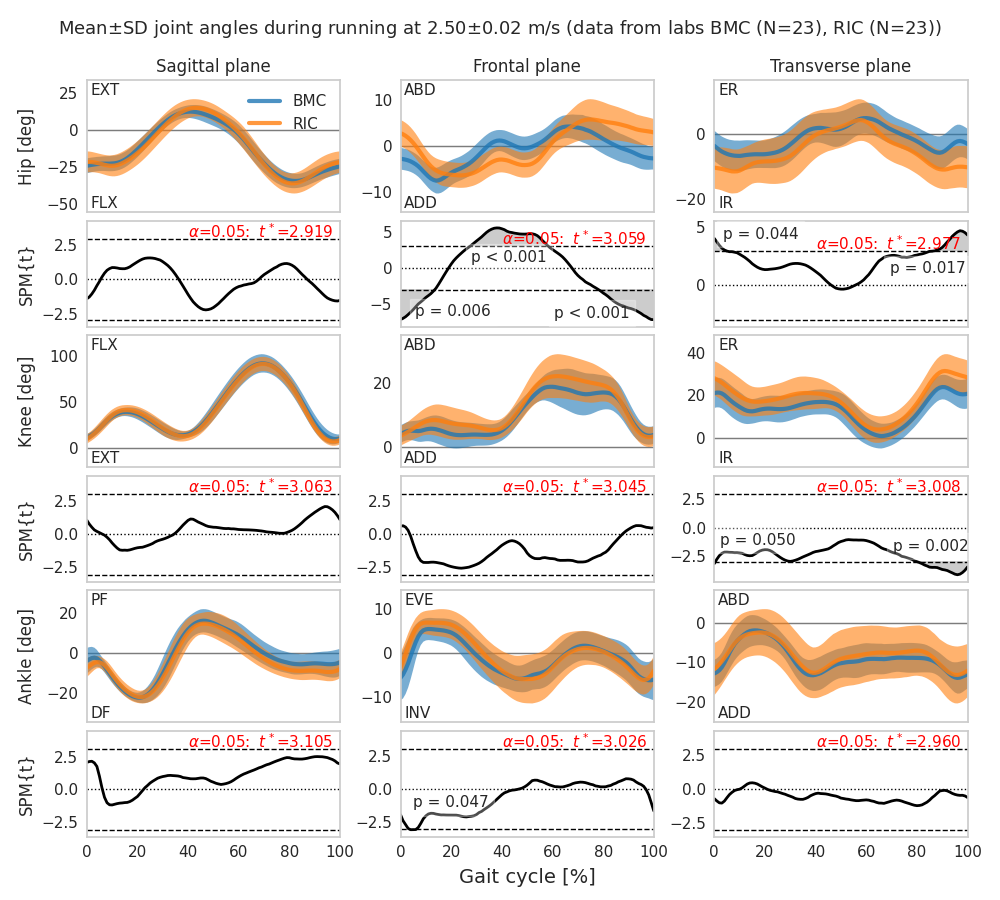

In [13]:
#@title #### Plot {display-mode: "form"}
tn = np.linspace(0, 100, 101)

# spm1d p-values offsets in plots
offsets = [[None, [(15, -1), (0, -3), (-15, -1)], [(16, 1), (-10, -2.5)]],
           [None, None, [(17, 2), (-5, 2)]],
           [None, [(15, +2)], None]]

heights = [1, .8, 1, .8, 1, .8]
widths  = [1, 1, 1]
fig, axs = plt.subplots(6, 3, figsize=(10, 9), sharex=True,
                        gridspec_kw={'height_ratios': heights, 'width_ratios': widths})
v_m, v_sd = metadata.Speed.mean(), metadata.Speed.std()
labs_s = [f'{lab} (N={len(metadata[metadata["Group"]==lab]["Filename"])})' for lab in labs]
labs_s = ', '.join(labs_s)
fig.suptitle(f'Mean$\pm$SD joint angles during running at {v_m:,.2f}$\pm${v_sd:,.2f} m/s (data from labs {labs_s})', fontsize=13)
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        for l, lab in enumerate(labs):
            axs[2*j, xyz].axhline(y=0, color=[0, 0, 0, .3], linestyle='-', zorder=-1)
            axs[2*j, xyz].plot(tn, ang_m[:, 3*j+xyz, l], label=labs[l], color=colors[l], alpha=.8, lw=3)
            axs[2*j, xyz].fill_between(tn,
                                       ang_m[:, 3*j+xyz, l] + ang_sd[:, 3*j+xyz, l],
                                       ang_m[:, 3*j+xyz, l] - ang_sd[:, 3*j+xyz, l],
                                       facecolor=colors[l], alpha=.6, edgecolor='none')

        # spm1d plots
        spm_ti[j, xyz].plot(ax=axs[2*j+1, xyz], color='k', plot_ylabel=False)
        spm_ti[j, xyz].plot_threshold_label(ax=axs[2*j+1, xyz], size=11)
        spm_ti[j, xyz].plot_p_values(ax=axs[2*j+1, xyz], size=11, offsets=offsets[j][xyz])
        #axs[2*j+1, xyz].spines[:].set_color(None)

        axs[2*j, xyz].set_ylabel(joint + '-' + planes[xyz])
        axs[2*j, xyz].set_xlim([0, 100]), axs[2*j+1, xyz].set_xlim([0, 100])
        axs[2*j, xyz].margins(y=0.2)
        axs[2*j, xyz].grid(False), axs[2*j+1, xyz].grid(False)
        axs[2*j, xyz].xaxis.set_ticks_position('none'), axs[2*j+1, xyz].xaxis.set_ticks_position('none')
        axs[2*j, xyz].yaxis.set_ticks_position('none'), axs[2*j+1, xyz].yaxis.set_ticks_position('none')
        axs[2*j, xyz].text(.015,  .89, f'{pos_angs[j][xyz]}', fontsize=11, transform=axs[2*j, xyz].transAxes)
        axs[2*j, xyz].text(.015, .03, f'{neg_angs[j][xyz]}', fontsize=11, transform=axs[2*j, xyz].transAxes)
        axs[2*j, xyz].tick_params(axis='both', which='major', pad=0)
        axs[2*j+1, xyz].tick_params(axis='both', which='major', pad=0)
        if j == 0:
            axs[0, xyz].set_title(f'{planes[xyz]} plane')
        if j == 2 and xyz == 1:
            axs[2*j+1, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
            axs[2*j+1, xyz].xaxis.set_label_coords(.5, -.3)
        if xyz == 0:
            axs[2*j, xyz].set_ylabel(f'{joint} [deg]', fontsize=12)
            axs[2*j+1, xyz].set_ylabel('SPM{t}', fontsize=12)
        else:
            axs[2*j, xyz].set_ylabel(''), axs[2*j+1, xyz].set_ylabel('')

fig.align_ylabels(axs[:, 0])
axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.3, w_pad=.05)
try:
    fig.savefig(f'{path2}{os_sep}"labs_angs_spm.png"', bbox_inches='tight')
except:
    print('Figure not saved in the cloud.')
plt.show()